# Computer Simulation: Output Analysis

**In the lab you will learn how to :**

* how to perform multiple replications of a simulation model implemented in simpy
* how to estimate and use warm-up period of a non-terminating simulation
* how to compare multiple competing scenarios



## Organisation of the notebook.

The main exercise in this notebook requires you to code the logic of a Minor Injury Unit. The notebook is provided with a number of classes and code to assist you in your model coding.  

* Distribution classes e.g. the `Exponential` distribution.
* A `Scenario` class to enable you to pass parameters to the model.
* Template classes to represent the Minor Injury Unit and the process patients follow.

**A video introduction (~30 mins) to the notebook, MIU problem and exercises is available [here](https://recapexeter.cloud.panopto.eu/Panopto/Pages/Viewer.aspx?id=83928f04-e118-48be-a2a4-ac7c00be5d5e)**

-----

# Imports

Please use the provided `hds_stoch` environment for this work.  

In [1]:
#!pip install simpy

import simpy
simpy.__version__

'3.0.12'

In [2]:
import numpy as np
import pandas as pd
import itertools
import math
import matplotlib.pyplot as plt

# Problem description: Modelling a minor injury unit

> In this lab we will again use the minor injury unit (MIU) model that we built previously. All of the code is provided below.  First, we have a brief reminder of the model.

In the UK, the NHS provides MIU's provide assessment and treatment for non-life threatening injuries.  For example, cuts and broken bones. 

The process flow below displays a high level process map of a MIU.  
* Patients arrive following a Poisson process, wait for nurse triage in one of **three triage bays**. 
* After triage is complete the patient waits for an assessment and treatment cubicle (there are **six**) where they are attended to by a nurse (here we assume the nurse is not a rate limiting step and we do not model nurse movement or availability).  
* Around **45%** of patients require diagnostics (e.g. an x-ray or other imaging) in addition to an assessment.  
* Around **75%** of diagnostics tests are booked by the nurse at the start of consultation with the remaining beginning their wait after the initial assessment.
* Patients who undergo diagnostics are seen by a nurse for a 2nd time following the completion of their diagnostics.

The duration of activities are:

| Activity 	| Activity name        	| Distribution 	| Mean (mins) 	| Standard Dev (minutes) 	|
|----------	|----------------------	|--------------	|-------------	|------------------------	|
| 1        	| IAT                  	| Non-stationary Poisson  	| See file         	|                        	|
| 2        	| 1st Assessment            	| Lognormal        	| 10          	| 3                      	|
| 3       	| Diagnostic waiting time  	| Exponential        	| 30          	|                       	|
| 4       	| 2nd Asessment  	| Lognormal        	| 10          	| 5                      	|


| Activity 	| Activity name        	| Distribution 	| Low 	| Mode 	| High |
|----------	|----------------------	|--------------	|-------------	|------------------------	| |
| 5        	| Triage                  	| Triangular  	| 2.0          	|   5.0                     	| 10.0|
| 6        	| Diagnostics           	| Triangular        	| 10.0          	| 15.0                      	|20.0 |




![image](images/minor_injury_process_flow.png)

# Distribution classes

These are the distribution classes we will use to run our model.

In [3]:
class Exponential():
    '''
    Convenience class for the exponential distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        mean: float
            The mean of the exponential distribution
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)

class Triangular():
    '''
    Convenience class for the triangular distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, low, mode, high, random_seed=None):
        self.rand = np.random.default_rng(seed=random_seed)
        self.low = low
        self.high = high
        self.mode = mode
        
    def sample(self, size=None):
        return self.rand.triangular(self.low, self.mode, self.high, size=size)
    
class Bernoulli():
    '''
    Convenience class for the Bernoulli distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, p, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        p: float
            probability of drawing a 1
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.p = p
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.binomial(n=1, p=self.p, size=size)

class Lognormal(object):
    """
    Encapsulates a lognormal distirbution
    """
    def __init__(self, mean, stdev, random_seed=None):
        """
        Params:
        -------
        mean = mean of the lognormal distribution
        stdev = standard dev of the lognormal distribution
        """
        self.rand = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma
        
    def normal_moments_from_lognormal(self, m, v):
        '''
        Returns mu and sigma of normal distribution
        underlying a lognormal with mean m and variance v
        source: https://blogs.sas.com/content/iml/2014/06/04/simulate-lognormal
        -data-with-specified-mean-and-variance.html

        Params:
        -------
        m = mean of lognormal distribution
        v = variance of lognormal distribution
                
        Returns:
        -------
        (float, float)
        '''
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2/phi)
        sigma = math.sqrt(math.log(phi**2/m**2))
        return mu, sigma
        
    def sample(self):
        """
        Sample from the normal distribution
        """
        return self.rand.lognormal(self.mu, self.sigma)

# Utility functions

In the simulation the `trace` function is used instead of `print`.  You can then control if a simulation outputs a trace of events by setting `TRACE = True` or turning event tracing off by setting `TRACE = False`.

In [4]:
def trace(msg):
    '''
    Utility function for printing simulation
    set the TRACE constant to FALSE to 
    turn tracing off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

# Model parameters and the `Scenario` class

* The constants below provides hard coded data representing the base case or 'as-is' state of the minor injury unit.   
* In the cell below the parameters you will find a `Scenario` class.  This makes use of the default parameters to set up the base case scenario.  Remember that its good practice to pass all of your parameters to your simulation model in a **container**.  A class is a flexible way to achieve this aim.

In [5]:
# These are the parameters for a base case model run.
#Note if you change these parameters then your model will run a new 'scenario' 

#resource counts
N_CUBICLES = 6
N_BAYS = 1

#time between arrivals in minutes is non-stationary (multiple exponentials)
#read in the data and calculate lambda
arrivals = pd.read_csv('data/miu_arrival_profile.csv')
arrivals['arrival_rate'] = arrivals['mean_arrivals_per_hour']

#triage (triangular)
TRIAGE_LOW = 2
TRIAGE_MODE = 5
TRIAGE_HIGH = 10

#assessment (lognormal)
ASSESS_MEAN = 10
ASSESS_STD = 3

#2nd assessment (lognormal)
ASSESS_MEAN_2 = 15
ASSESS_STD_2 = 5

#diagnostics (bernoulli)
PROB_DIAG = 0.45 

#diagnostics waiting time (exp)
DIAG_WT_MEAN = 20

#diagnostics process time (triangular)
DIAG_PT_LOW = 10
DIAG_PT_MODE = 15
DIAG_PT_HIGH = 20

#% in parallel (bernoulli)
P_PARALLEL = 0.75

#SEEDS to reproduce results of a single run
REPRODUCIBLE_RUN = False
    
if REPRODUCIBLE_RUN:
    SEEDS = [42, 101, 1066, 1966, 2013, 999, 1444, 2016, 2020]
else:
    SEEDS = [None, None, None, None, None, None, None, None, None]

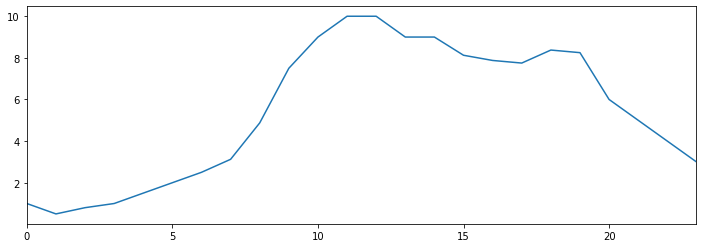

In [6]:
#let's take a look at the arrival process.
arrivals['arrival_rate'].plot(figsize=(12,4), xlim=(0, 23))

In [7]:
class Scenario:
    '''
    Parameter container class for minor injury unit model.
    '''
    def __init__(self, name=None):
        '''
        The init method sets up our defaults. 
        
        Params:
        -------
        
        name - str or None
            optional name for scenario
        '''
        #optional name
        self.name = name
        
        #triage bays
        self.n_triage_bays = N_BAYS
        
        #assessment and treatment cubicles
        self.n_minor_cubicles = N_CUBICLES
        
        #inter-arrival distribution with maximum IAT
        self.arrivals = arrivals
        
        #triage distribution
        self.triage_dist = Triangular(TRIAGE_LOW, TRIAGE_MODE, TRIAGE_HIGH, 
                                      random_seed=SEEDS[2])
        
        #assessment distribution
        self.assessment_dist = Lognormal(ASSESS_MEAN, ASSESS_STD, 
                                         random_seed=SEEDS[3])
        
        #diagnostics: prob that patient needs imaging etc.
        self.n_diagnostics_minor = Bernoulli(PROB_DIAG, random_seed=SEEDS[4])
        
        #waiting and process time dists for diagnostics
        self.diag_wait_dist = Exponential(DIAG_WT_MEAN, random_seed=SEEDS[5])
        self.diag_dist = Triangular(DIAG_PT_LOW, DIAG_PT_MODE, DIAG_PT_HIGH,
                                    random_seed=SEEDS[6])
        
        #prob diagnostics done in parallel to nurse assessment
        self.p_diag_parallel = Bernoulli(P_PARALLEL, random_seed=SEEDS[7])
        
        #2nd assessment distribution
        self.assessment_dist_2 = Lognormal(ASSESS_MEAN_2, ASSESS_STD_2, 
                                           random_seed=SEEDS[8])


---
# Model Logic


The simpy process logic for the MIU is contained within two classes `MinorInjuryUnit` and `MinorPatient`

In [8]:
class MinorInjuryUnit:  
    '''
    Model of an minor injury unit
    '''
    def __init__(self, env, args, thinning_seed1=None, thinning_seed2=None):
        '''
        Contructor
        
        Params:
        -------
        env: simpy.Environment
        
        args: Scenario
            container class for simulation model inputs.
        '''
        self.env = env
        self.args = args 
        self.init_model_resources(args)
        
        #rng generators used for thinning
        self.arr_rng = np.random.default_rng(thinning_seed1)
        self.thinning_rng = np.random.default_rng(thinning_seed2)
        
        #hold a list of patients.
        self.patients = []
        
        
    def init_model_resources(self, args):
        '''
        Setup the simpy resource objects
        
        Params:
        ------
        args - Scenario
            Simulation Parameter Container
        '''
        args.triage_bays = simpy.Resource(self.env, 
                                          capacity=args.n_triage_bays)
        args.minor_cubicles = simpy.Resource(self.env, 
                                             capacity=args.n_minor_cubicles)
        
            
    def arrivals_generator(self):
        '''
        IAT is exponentially distributed

        Parameters:
        ------
        env: simpy.Environment

        args: Scenario
            Container class for model data inputs
        '''
        for patient_count in itertools.count(start=1):
            #sample non-stationary inter-arrival time via thinning
            inter_arrival_time = self.nspp_via_thinning()
            yield self.env.timeout(inter_arrival_time)

            trace(f'patient {patient_count} arrives at: {self.env.now:.3f}')

            #create a new minor patient and pass in env and args
            new_patient = MinorPatient(patient_count, self.env, self.args)
            
            #keep a record of the patient for results calculation
            self.patients.append(new_patient)
            
            #init the minor injury process for this patient
            self.env.process(new_patient.assessment())
            
            
    def nspp_via_thinning(self):

        #maximum arrival rate (smallest time between arrivals)
        lambda_max = self.args.arrivals['arrival_rate'].max()
        self.hist = np.zeros(shape=(24,))
        for n in itertools.count():

            # this give us the index of dataframe to use
            t = int(self.env.now // 60) % 24
            self.hist[t] += 1
            lambda_t = self.args.arrivals['arrival_rate'].iloc[t]

            #set to a large number so that at least 1 sample taken!
            u = np.Inf
            # reject samples if u >= lambda_t / lambda_max
            while u >= (lambda_t / lambda_max):
                interarrival_time = self.arr_rng.exponential(60/lambda_max)
                u = self.thinning_rng.uniform(0, 1)

            return interarrival_time     
        
            


In [9]:
#example solution ....
class MinorPatient(object):
    '''
    Patient in the minor ED process
    '''
    def __init__(self, identifier, env, args):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        args: Scenario
            The input data for the scenario
        '''
        #patient id and environment
        self.identifier = identifier
        self.env = env

        #triage parameters
        self.triage_bays = args.triage_bays
        self.triage_dist = args.triage_dist
    
        #minor assessment parameters
        self.minor_cubicles = args.minor_cubicles
        self.assessment_dist = args.assessment_dist
        self.assessment_dist_2 = args.assessment_dist_2
        
        #diagnostics: prob that patient needs imaging etc.
        self.n_diagnostics_dist = args.n_diagnostics_minor
        
        #prob diagnostics done in parallel to nurse assessment
        self.p_diag_parallel = args.p_diag_parallel
        
        #waiting and process time dists for diagnostics
        self.diag_wait_dist = args.diag_wait_dist 
        self.diag_dist = args.diag_dist
                
        # individual patient metrics
        self.time_to_triage = 0.0
        self.time_to_nurse = 0.0
        self.time_in_system = 0.0
        self.four_hour_target = 0.0
        
        #track patient arrival time.
        self.arrival_time = 0.0
        
    
    def assessment(self):
        '''
        simulates the process for minor emergencies
        
        1. request and wait for triage
        2. request and wait for a minor cubicle
        3. minor assessment
        4. exit system.
        
        '''
        #record the time that patient entered the system
        self.arrival_time = self.env.now

        #request an operator 
        with self.triage_bays.request() as req:
            yield req
                        
            trace(f'minor triage {self.identifier} at {self.env.now:.3f}')
            
            #time to triage
            self.time_to_triage = self.env.now - self.arrival_time
            
            #sample triage duration.
            triage_duration = self.triage_dist.sample()
           
            yield self.env.timeout(triage_duration)            
            
            trace(f'triage ended {self.identifier} ended {self.env.now:.3f}; '
                      + f'waiting time: {self.env.now - self.arrival_time:.3f}')
            
        
        #get cubicle
        with self.minor_cubicles.request() as req:
            yield req
            
            #record time to first being seen by a nurse
            self.time_to_nurse = self.env.now - self.arrival_time
            
            trace(f'minor assessment {self.identifier} at {self.env.now:.3f}; '
                      + f' time to nurse was {self.time_to_nurse:.3f}')
            
            #sample for patient pathway
            assess_time, n_diagnostics, \
                parallel, diag_wt, diag_pt, assess_time_2 = self.sample_all()
            
            #patient undergoing diagnostics?
            if n_diagnostics > 0:

                #in parallel to minor assessment?
                if parallel:
                    
                    trace(f'parallel diagnostics patient {self.identifier}')
                    
                    #use the longest delay for assessment 1
                    activity_duration = max(assess_time, diag_wt + diag_pt)
                    
                else:
                    
                    trace(f'diagnostics following assessment for '
                          + f'patient {self.identifier}')
                    
                    #use the total delay for assessment 1
                    activity_duration = assess_time + diag_wt + diag_pt 
            else:
                activity_duration = assess_time
            
          
            #assessment 1 delay
            yield self.env.timeout(activity_duration)
            
            if n_diagnostics > 0:
                #assessment 2 delay
                
                trace(f'{self.identifier} enters 2nd assessment'
                      + f' at {self.env.now:.3f}')
                         
                yield self.env.timeout(assess_time_2)
                
                trace(f'{self.identifier} completes 2nd assessment'
                      + f' at {self.env.now:.3f}')
            
            #time in system for this patient
            self.time_in_system = self.env.now - self.arrival_time
            
            trace(f'{self.identifier} departs at {self.env.now:.3f}; '
                      + f' time in system{self.time_in_system:.3f}')
            
            if self.time_in_system <= (4 * 60):
                self.four_hour_target = 1
            
                        
    def sample_all(self):
        '''
        Sample assessment time, if the patient requires diagnostics,
        if the diags are done in parallel to assessment and 
        '''

        #sample assessment time
        assess_time = self.assessment_dist.sample()

        #will the patient need diagnostics?
        n_diagnostics = self.n_diagnostics_dist.sample()

        if n_diagnostics > 0:
            #will the diagnostics be in parallel with assessment
            parallel = self.p_diag_parallel.sample()

            #diagnostic waiting time
            diag_wt = self.diag_wait_dist.sample()

            #diagnostic process time
            diag_pt = self.diag_dist.sample()
            
            #second assessment time
            assess_time_2 = self.assessment_dist_2.sample()

            return (assess_time, n_diagnostics, parallel, diag_wt, diag_pt,
                    assess_time_2)
        else:
            return assess_time, n_diagnostics, _, _, _, 0
    

---
# Exercise 1: Performing a single run of the model.

This exercise is a reminder of how to perform a single run of the model and how to organise your code in functions.  You will see the real benefit of using functions in exercise 2.  

You will investigate the following scenarios:

* 1 extra triage bay
* 1 extra cubicle
* 5 extra cubicles
* 1 extra triage bay + 1 extra cubicle

## Using functions to organise experimentation.

**As a reminder**, in practice, it is a good idea to use functions to help you efficiently run scenarios.  

### `single_model_run()`

The function `single_model_run` has been provided to help you do that.  Take a look at it first.  Note that it is very similar to your previous script.   It accepts a parameter `scenario` which contains all of the parameters you wish to use for the run.  When the model run is complete it returns the performance desired performance measures. The seperates the creation of the scenarios from your model run code.

### `get_scenarios()`

A sensible way to organise experimentation is to create all of scenarios in advance, store them in a python `list` or `dict` and then loop through the passing each to the `single_model_run` function.   The function `get_scenarios` has been coded for you, and contains an example of creating scenarios.  As part of the exercise you will need to complete the code and add in the extra scenarios.

> Note in practice if you are working with big complex models you may want to store all of your scenarios and parameters in a CSV file.  You can then read them in.  Here we have a simple model so we are hard coding everything for clarity.

**Task**
* Read and check you understand the functions and script provided.
* Run the code below to create the functions and then run the script.  This will output the results of a single run.

In [10]:
def single_model_run(scenario, run_length):
    '''
    Perform a single run of the model and return the results
    
    Params:
    -------
    
    env = Simpy.Environment
    
    scenario - Scenario object
        The scenario/paramaters to run
        
    run_length - int
        The length of the simulation run.
        
        
    Returns:
        Tuple:
        (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
         four_hours)
    '''
    env = simpy.Environment()
    #create the model and pass in scenario
    model = MinorInjuryUnit(env, scenario, SEEDS[0], SEEDS[1])

    #setup the process
    env.process(model.arrivals_generator())
    
    #run
    env.run(until=run_length)
    
    #Performance metrics

    #1. mean time in system
    mean_time_in_system = np.array([patient.time_in_system 
                                    for patient in model.patients]).mean()


    #2. mean time to first treatment
    mean_time_to_nurse = np.array([patient.time_to_nurse 
                                   for patient in model.patients]).mean()

    #3. mean time to triage
    mean_time_to_triage = np.array([patient.time_to_triage 
                                   for patient in model.patients]).mean()


    #4. four hour target
    four_hours = np.array([patient.four_hour_target 
                           for patient in 
                           model.patients]).sum() / len(model.patients)
        
    #return results.
    return (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
            four_hours)

In [11]:
def get_scenarios():
    #sometime useful to store scenarios in a list or dict
    scenarios = {}
    #default scenario
    scenarios['base'] = Scenario()
    scenarios['base'].name = 'base'

    #this scenario has an extra triage bay
    scenario_1 = Scenario()
    scenario_1.triage_bays = N_BAYS + 1
    scenarios['extra_triage_capacity'] = scenario_1
    scenarios['extra_triage_capacity'].name = 'extra_triage_capacity'
    
    #################### Your code here ###############################
    
    #Scenarios to add:
    #1. 1 extra minor cubicle
    #2. 5 extra minor cubicles
    #3. 1 extra triage bay
    #4. 1 extra minor cubicle and 1 extra triage bay
    
    #your code here..
    #extra minor cubicle
    scenario_2 = Scenario()
    scenario_2.n_minor_cubicles = N_CUBICLES + 10000
    scenarios['extra_cubicle'] = scenario_2
    scenarios['extra_cubicle'].name = 'extra_cubicle'
    
    
    #your code here..
    #5 extra minor cubicles
    scenario_3 = Scenario()
    scenario_3.n_minor_cubicles = N_CUBICLES + 5
    scenarios['5_extra_cubicles'] = scenario_3
    scenarios['5_extra_cubicles'].name = '5_extra_cubicles'
    
    
    #your code here
    #1 extra cubicle and 1 extra triage bay
    scenario_4 = Scenario()
    scenario_4.n_minor_cubicles = N_CUBICLES + 1
    scenario_4.n_triage_bays = N_BAYS + 1
    scenarios['combination'] = scenario_4
    scenarios['combination'].name = 'combination'
        
    return scenarios

### Script to run the scenarios.

In [12]:
RUN_LENGTH = 1440
TRACE = False

#load scenarios using your function
scenarios = get_scenarios()

#create simpy environment
env = simpy.Environment()

#loop through each scenario and store results in a dict
results = {}
for name, scenario in scenarios.items():
    
    print(f'simulating scenario: {name}')
    results[name] = single_model_run(scenario, RUN_LENGTH)
print('All simulations complete.\n\n')

#convert results to dataframe and printout
results = pd.DataFrame(results).T
results.columns = ['Time in System', 'Time to Nurse', 'Time to Triage', 
                   '4 Hr performance']
results

simulating scenario: base
simulating scenario: extra_triage_capacity
simulating scenario: extra_cubicle
simulating scenario: 5_extra_cubicles
simulating scenario: combination
All simulations complete.




,Time in System,Time to Nurse,Time to Triage,4 Hr performance
base,83.169532,54.806912,46.199275,0.922449
extra_triage_capacity,55.582596,32.405438,25.879625,0.930041
extra_cubicle,67.585246,40.524831,34.965059,0.984064
5_extra_cubicles,71.402332,49.127636,44.110737,0.918288
combination,41.356681,10.836540,0.714610,0.978814


# Exercise 2: Performing multiple replications of a single scenario

Here is where the benefit of using functions to organise your experimentation really pays off!  To perform multiple replications we just need to call `single_model_run` multiple times in a loop.

**Task**:

* Create a function called `multiple_replications`.  The function should accept the following parameters:
   * scenario: `Scenario` - Parameters/arguments to configurethe model
   * runlength: `int` - number of minutes to run the model in simulated time
   * n_reps: `int`, optional (default=5) - Number of independent replications to run.
* The purpose of `multiple_replications` is to conduct `n_reps` independent replications of the MIU model.
* The function should return a list of results.
* After coding the function make use of the script provided to run 5 independent replications of the MIU model and output the value of each performance measure in each replication.

**Questions**
* What is the mean performance of the model with 5 replications?

**Hints**
* Try calling `single_model_run` in a for loop
* Alternatively you could make use of a list comprehension.



In [13]:
#your code here...

In [16]:
#example solution
def multiple_replications(scenario, runlength, n_reps=5):
    '''
    Perform multiple replications of the MIU model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    runlength: int
        number of minutes to run the model in simulated time
        
    n_reps: int, optional (default=5)
        Number of independent replications to run.
        
    Returns:
    --------
    List
    '''
    results = [single_model_run(scenario, runlength) 
               for i in range(n_reps)]
    return results
        

In [17]:
#script

RUN_LENGTH = 1440
TRACE = False

#make sure this is set to True otherwise you will get the same result in 
#each replication.
MULTIPLE_REPLICATION_MODE = True

#load scenarios using your function
default_args = Scenario()

#create simpy environment
env = simpy.Environment()

print('Running replications...')
#perform multiple replications
results = multiple_replications(default_args, RUN_LENGTH, n_reps=5)

#convert results to dataframe and printout
results = pd.DataFrame(results)
results.columns = ['Time in System', 'Time to Nurse', 'Time to Triage', 
                   '4 Hr performance']

#print results of each replication.
results



Running replications...


,Time in System,Time to Nurse,Time to Triage,4 Hr performance
0,46.062657,19.095133,10.672943,0.968468
1,61.991951,34.545310,27.065518,0.987552
2,67.241915,40.396050,32.942032,0.930131
3,45.692228,20.399792,13.451480,0.974684
4,72.661028,46.064336,32.512713,0.937238


In [18]:
#mean results
results.mean()

Time in System      58.729956
Time to Nurse       32.100124
Time to Triage      23.328938
4 Hr performance     0.959615
dtype: float64

# Exercise 3: Estimating and including a the warm-up period in the model.

Our MIU model is a non-terminating simulation.  To estimate a warm-up period of the model we will use the **time series inspection approach**.  We will run 5 replications of the model and plot the mean performance measures over time.  We the choose a warm-up that allows the model to settle to a steady state.

In [19]:
class Auditor():
    def __init__(self, env, model, interval):
        self.env = env
        self.model = model
        self.interval = interval
        self.time_in_system = []
        self.time_to_triage = []
        self.time_to_nurse = []
        self.four_hours = []
        
    def audit_model(self):
        for i in itertools.count():
            yield self.env.timeout(self.interval)

            #Performance metrics

            #1. mean time in system
            mean_time_in_system, mean_time_to_nurse, mean_time_to_triage, \
                four_hours = model_performance_measures(self.model)
            
            self.time_in_system.append(mean_time_in_system)
            self.time_to_triage.append(mean_time_to_triage)
            self.time_to_nurse.append(mean_time_to_nurse)
            self.four_hours.append(four_hours)

        return results

In [20]:
def model_performance_measures(model):
    #Performance metrics

    #1. mean time in system
    mean_time_in_system = np.array([patient.time_in_system 
                                    for patient in model.patients]).mean()


    #2. mean time to first treatment
    mean_time_to_nurse = np.array([patient.time_to_nurse 
                                   for patient in model.patients]).mean()

    #3. mean time to triage
    mean_time_to_triage = np.array([patient.time_to_triage 
                                   for patient in model.patients]).mean()


    #4. four hour target
    four_hours = np.array([patient.four_hour_target 
                           for patient in 
                           model.patients]).sum() / len(model.patients)
        
    #return results.
    return (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
            four_hours)

In [76]:
def single_model_run(scenario, results_collection, warm_up=0, 
                     include_audit=False, audit_interval=60):
    '''
    Perform a single run of the model and return the results
    
    Params:
    -------
    
    env = Simpy.Environment
    
    scenario - Scenario object
        The scenario/paramaters to run
        
    run_length - int
        The length of the simulation run.
        
        
    Returns:
        Tuple:
        (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
         four_hours)
    '''
    env = simpy.Environment()
    #create the model and pass in scenario
    model = MinorInjuryUnit(env, scenario)

    
    #setup the arrival process
    env.process(model.arrivals_generator())
    
    #setup the audit process
    if include_audit:
        audit = Auditor(env, model, AUDIT_INTERVAL)
        env.process(audit.audit_model())
    
    #run
    env.run(until=results_collection+warm_up)
    
    #return results.
    if include_audit:
        return model_performance_measures(model), audit
    else:
        return model_performance_measures(model)

In [77]:
#example solution
def multiple_replications(scenario, results_collection, warm_up=0, n_reps=5, 
                          include_audit=False, audit_interval=60):
    '''
    Perform multiple replications of the MIU model.
    
    Params:
    ------
    scenario: Scenario
        Parameters/arguments to configurethe model
    
    runlength: int
        number of minutes to run the model in simulated time
        
    n_reps: int, optional (default=5)
        Number of independent replications to run.
        
    Returns:
    --------
    List
    '''
    results = [single_model_run(scenario, results_collection, warm_up, 
                                include_audit, audit_interval) 
               for i in range(n_reps)]
    return results
        

In [78]:
#script

RUN_LENGTH = 1440 * 40
TRACE = False
INCLUDE_AUDIT = True
AUDIT_INTERVAL = 90
N_REPS = 10

#load scenarios using your function
default_args = Scenario()

#create simpy environment
env = simpy.Environment()

print('Running multiple replications...')
#perform multiple replications
results = multiple_replications(default_args, RUN_LENGTH, n_reps=N_REPS,
                                include_audit=INCLUDE_AUDIT)

print('Complete')




Running multiple replications...
Complete


In [79]:
metrics = {'time_to_triage':[],
           'time_to_nurse':[],
           'time_in_system':[],
           'four_hours':[]}

#print results of each replication.
for audit in np.array(results):
    metrics['time_to_triage'].append(audit[1].time_to_triage)
    metrics['time_to_nurse'].append(audit[1].time_to_nurse)
    metrics['time_in_system'].append(audit[1].time_in_system)
    metrics['four_hours'].append(audit[1].four_hours)
    


Text(0, 0.5, 'four_hours')

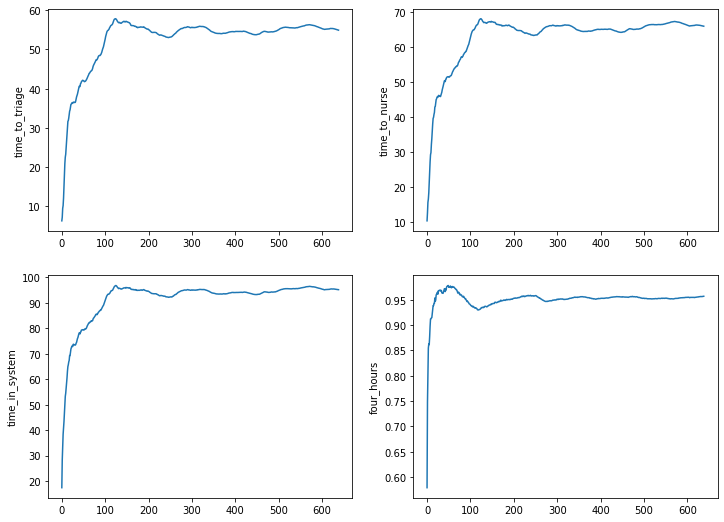

In [80]:
fig, ax = plt.subplots(2, 2, figsize=(12,9))
ax[0][0].plot(np.array(metrics['time_to_triage']).mean(axis=0))
ax[0][1].plot(np.array(metrics['time_to_nurse']).mean(axis=0))
ax[1][0].plot(np.array(metrics['time_in_system']).mean(axis=0))
ax[1][1].plot(np.array(metrics['four_hours']).mean(axis=0))

ax[0][0].set_ylabel('time_to_triage')
ax[0][1].set_ylabel('time_to_nurse')
ax[1][0].set_ylabel('time_in_system')
ax[1][1].set_ylabel('four_hours')

In [81]:
# Adding warm up to the model




In [82]:
def model_performance_measures(model, warmup=0):
    #Performance metrics

    #1. mean time in system
    mean_time_in_system = np.array([patient.time_in_system 
                                    for patient in model.patients
                                    if patient.arrival_time > warmup]).mean()


    #2. mean time to first treatment
    mean_time_to_nurse = np.array([patient.time_to_nurse 
                                   for patient in model.patients
                                   if patient.arrival_time > warmup]).mean()

    #3. mean time to triage
    mean_time_to_triage = np.array([patient.time_to_triage 
                                   for patient in model.patients
                                   if patient.arrival_time > warmup]).mean()


    #4. four hour target
    four_hours = np.array([patient.four_hour_target 
                           for patient in 
                           model.patients if patient.arrival_time > warmup]
                          ).sum() / len(model.patients)
        
    #return results.
    return (mean_time_in_system, mean_time_to_nurse, mean_time_to_triage,
            four_hours)

In [90]:
def results_summary(results):
    
    #convert results to dataframe and printout
    results = pd.DataFrame(results)
    results.columns = ['Time in System', 'Time to Nurse', 'Time to Triage', 
                       '4 Hr performance']

    return results.mean()

In [206]:
#script

INCLUDE_AUDIT = False
AUDIT_INTERVAL = 90
WARM_UP = 200 * AUDIT_INTERVAL
RESULTS_COLLECTION = 1440
RUN_LENGTH = WARM_UP + RESULTS_COLLECTION
TRACE = False

N_REPS = 150

#load scenarios using your function
default_args = Scenario()

#create simpy environment
env = simpy.Environment()

print('Running multiple replications...')
#perform multiple replications
results = multiple_replications(default_args, RUN_LENGTH, n_reps=N_REPS,
                                include_audit=INCLUDE_AUDIT)

print('Complete')

results_summary(results)

Running multiple replications...
Complete


Time in System      88.319135
Time to Nurse       59.512669
Time to Triage      48.709499
4 Hr performance     0.971325
dtype: float64

# End

In [207]:
from scipy.stats import t

def confidence_interval_method(replications, alpha=0.05, decimal_place=2):
    n = len(replications)
    cumulative_mean = [replications[0]]
    running_var = [0.0]
    for i in range(1, n):
        cumulative_mean.append(cumulative_mean[i-1] + \
                       (replications[i] - cumulative_mean[i-1] ) / (i+1))
        
        #running biased variance
        running_var.append(running_var[i-1] + (replications[i] 
                                               - cumulative_mean[i-1]) \
                            * (replications[i] - cumulative_mean[i]))
        
    #unbiased std dev = running_var / (n - 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        running_std = np.sqrt(running_var / np.arange(n))
    
    #half width of interval
    dof = len(replications) - 1
    t_value = t.ppf(1 - (alpha / 2),  dof)    
    with np.errstate(divide='ignore', invalid='ignore'):
        std_error = running_std / np.sqrt(np.arange(1, n+1))
    half_width = t_value * std_error
    
    #upper and lower confidence interval
    upper = cumulative_mean + half_width
    lower = cumulative_mean - half_width
    
    #Mean deviation
    with np.errstate(divide='ignore', invalid='ignore'):
        deviation = (half_width / cumulative_mean) * 100
    
    results = pd.DataFrame([replications, cumulative_mean, 
                            running_std, lower, upper, deviation]).T
    
    results.columns = ['Mean', 'Cumulative Mean', 'Standard Deviation', 
                       'Lower Interval', 'Upper Interval', '% deviation']
    
    results.index = np.arange(1, n+1)
    results.index.name = 'replications'
    return results.round(2)
        

In [208]:
reps_tis = [results[i][0] for i in range(len(results))]    

In [209]:
conf_intervals = confidence_interval_method(reps_tis)
conf_intervals

,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
1,112.17,112.17,NaN,NaN,NaN,NaN
2,86.21,99.19,18.36,73.54,124.85,25.86
3,85.10,94.49,15.32,77.01,111.97,18.50
4,108.89,98.09,14.44,83.83,112.36,14.54
5,69.61,92.40,17.85,76.62,108.17,17.07
...,...,...,...,...,...,...
146,75.84,87.64,19.04,84.53,90.75,3.55
147,98.20,87.71,18.99,84.61,90.81,3.53
148,98.67,87.78,18.95,84.71,90.86,3.51


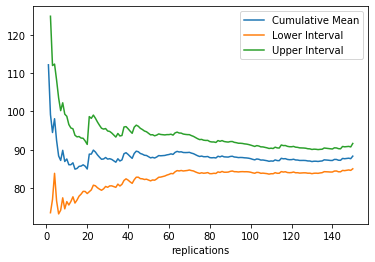

In [210]:
conf_intervals[['Cumulative Mean', 'Lower Interval', 'Upper Interval']].plot()

In [215]:
#find interval with mean deviation < 5%.
conf_intervals.loc[conf_intervals['% deviation'] <= 5.0][:10]

,Mean,Cumulative Mean,Standard Deviation,Lower Interval,Upper Interval,% deviation
replications,,,,,,
75,73.35,88.23,19.33,83.82,92.64,5.00
76,95.76,88.33,19.22,83.97,92.69,4.93
77,75.60,88.17,19.15,83.85,92.48,4.89
78,88.29,88.17,19.02,83.91,92.42,4.83
79,92.64,88.22,18.91,84.02,92.43,4.76
80,64.51,87.93,18.97,83.74,92.12,4.77
81,84.29,87.88,18.86,83.74,92.02,4.71
82,91.55,87.93,18.75,83.84,92.02,4.65
83,81.03,87.84,18.65,83.80,91.89,4.60
